# 545 Final Project
Vyom Raval

March 16, 2023

## Introduction
Publio (2009) published their code for a compartment model-based simulation of the rod pathway on model DB [here](https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=124063&file=/PublioEtAl2009/createcells.hoc#tabs-1). The code is written in the NEURON simulation environment and specifies differential equations and parameters for each current component (ion channel or otherwise like leak) and cell type in the pathway.

Translating the code into python reveals several details left out of the paper.

For this project, I was only able to get a reasonable replication of the rod model, which is more fully described in Publio (2006). To begin, let's look at the input photocurrent equation:

$I = I_{dark} + A[(1 - exp(\frac{-t}{\tau_1})) - (\frac{1}{1+exp(\frac{-(t-b)}{\tau_2})}) + (1 - exp(\frac{-t}{\tau_3}))]$

The A coefficient controls the amplitude of the photocurrent and could represent input light intensity.

We can implement this equation using the brian2 package

In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Photocurrent parameters
Idark = -40*pA
Tau1 = 50*ms
Tau2 = 450*ms
Tau3 = 800*ms
RodB = 3800*ms

# Brian2 takes in equations in a string format
eqs_input = '''
# input photocurrent
Ip = Idark + A*((1-exp(-t/Tau1)) - (1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3))): amp
A : amp
'''

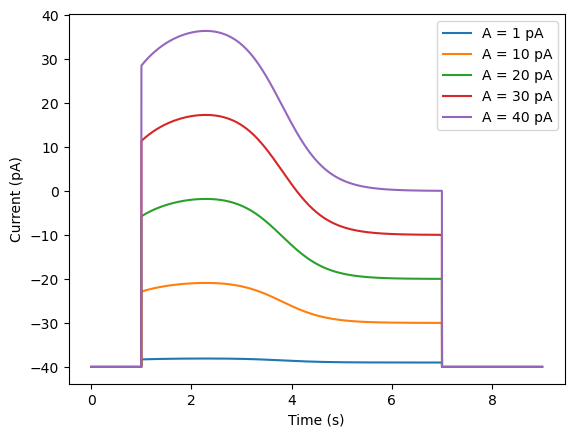

In [3]:
# Simulate model in Brian2 with range of input amplitudes
for input_amp in [1, 10, 20, 30, 40]:
    start_scope() # This is a helper function to clear all variables
    G = NeuronGroup(1, eqs_input, method='euler') # define 1 model neuron with input eqs
    M = StateMonitor(G, 'Ip', record=True) # record photocurrent
    
    # Initialize input current to 0 and run for 1s, then set to input_amp and run for 6s, then set to 0 and run for 2s
    G.A = 0*pA 
    run(1000*ms)
    G.A = input_amp*pA
    run(6000*ms)
    G.A = 0*pA
    run(2000*ms)
    
    # Plot photocurrent
    plot(M.t/second, M.Ip[0]/pA, label=f'A = {input_amp} pA')
    xlabel('Time (s)')
    ylabel('Current (pA)')
legend();

Fig1 in Publio(2009)

Left: rod output voltage. Right: Input photocurrent.

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0006970.g001" width=400>

Well the waveform looks way off from the paper. Looking directly at the code for the photocurrent reveals additional coefficients that are not mentioned in the paper. The equation is actually:

$I = I_{dark} + A\frac{[32\cdot(1 - exp(\frac{-t}{\tau_1})) - 33\cdot(\frac{1}{1+exp(\frac{-(t-b)}{\tau_2})}) + (1 - exp(\frac{-t}{\tau_3}))]}{33}$

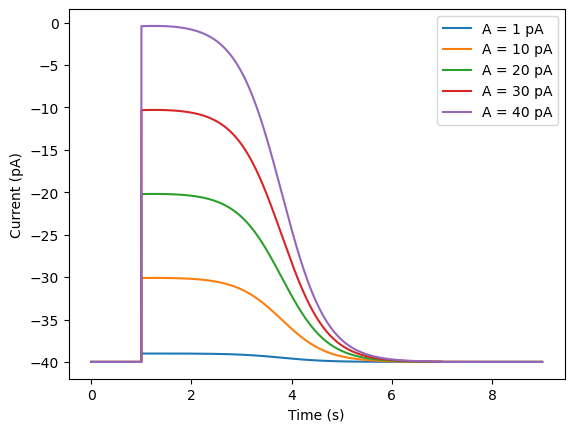

In [5]:
eqs_input = '''
# input photocurrent
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp
'''

# Same simulation as earlier with correct equation
for input_amp in [1, 10, 20, 30, 40]:
    start_scope()
    G = NeuronGroup(1, eqs_input, method='euler')
    M = StateMonitor(G, 'Ip', record=True)
    G.A = 0*pA
    run(1000*ms)
    G.A = input_amp*pA
    run(6000*ms)
    G.A = 0*pA
    run(2000*ms)
    plot(M.t/second, M.Ip[0]/pA, label=f'A = {input_amp} pA')
    xlabel('Time (s)')
    ylabel('Current (pA)')
legend();

Now that matches the paper! The modified equation effectively down-weights the third component, which has the longest time constant of 800ms, by a factor of 33. The result matches our intuition that the slow sinusoidal component disappears and is dominated by a fast decay to rest.

This pattern of hidden coefficients and parameters holds true for most equations. The following blocks of code are python translations of the NEURON code.

## Rod Model

Ileak is defined in Rod_leak.mod

Note that the code has 1e-3 in the equation to convert glbar from S to mS. This is not needed in brian2 as it handles units automatically.

In [6]:
# Define Rod_leak
glbar = 0.52*msiemens*cm**-2
El_rev = -74*mV

eqs_leak = '''
Ileak = glbar * (V-El_rev) : amp / metre**2
'''

Rod_ih.mod

There are 0.001 coefficients here too and it is unclear if they are unit conversions or part of the equation. I have left them out as testing showed a closer result to desired.

In [7]:
# Define Rod_ih
Eh_rev = -32*mV
Vhalf_h = -82*mV
gh_bar = 2.5*msiemens*cm**-2
Sh = -5.33*mV
aoh = 1*Hz

# Brian2 accomodates differential equations in the format dx/dt = f(x)
eqs_h = '''
ah = aoh*exp( (V-Vhalf_h)/(2*Sh) ) : Hz
bh = aoh*exp( -(V-Vhalf_h)/(2*Sh) ) : Hz
tauh = 1/(ah+bh) : second
infh = ah*tauh : 1

dnh/dt = (infh-nh)/tauh : 1
gh = gh_bar * nh : siemens / metre**2
Ih = gh * (V-Eh_rev) : amp / metre**2
'''

Rod_Kv.mod

In [8]:
# Define Rod_Kv
EKv_rev = -80*mV # Was -74mV
gKv_bar = 10*msiemens*cm**-2

eqs_Kv = '''
gKv = gKv_bar * (mKv**4) : siemens / metre**2
IKv = gKv * (V-EKv_rev) : amp / metre**2
dmKv/dt = (infmKv - mKv)/taumKv : 1

alphamKv = 0.005 * (20-V/mV)/(exp((20-V/mV)/22)-1)/ms : Hz
betamKv = 1/16 * exp(-V/mV/80)/ms : Hz

taumKv = 1/(alphamKv+betamKv) : second
infmKv = alphamKv * taumKv : 1
'''

Rod_Kx.mod

In [9]:
# Define Rod_Kx
EKx_rev = -74*mV
gKx_bar = 1.04*msiemens*cm**-2
Vhalf_Kx = -49.9*mV
SKx = 5.7*mV
aoKx = 0.66*Hz

eqs_Kx = '''
aKx = aoKx*exp( (V-Vhalf_Kx)/(2*SKx) ) : Hz
bKx = aoKx*exp( -(V-Vhalf_Kx)/(2*SKx) ) : Hz
tauKx = 1/(aKx+bKx) : second
infKx = aKx*tauKx : 1

dnKx/dt = (infKx-nKx)/tauKx : 1

gKx = gKx_bar * nKx : siemens / metre**2
IKx = gKx * (V-EKx_rev) : amp / metre**2
'''

Rod_Ca.mod

In [10]:
# Define Rod_Ca
gCabar = 4*msiemens*cm**-2
ECa_rev = 40*mV
aomCa = 100*Hz
bomCa = 100*Hz
gammaohCa = 10*Hz
deltaohCa = 10*Hz

VhalfCam = -10*mV
VhalfCah = 11*mV

SCam = 6*mV
SCah = 9*mV

eqs_Ca = '''
alphamCa = 0.001*aomCa*exp( (V-VhalfCam)/(2*SCam) ) : Hz
betamCa = 0.001*bomCa*exp( -(V-VhalfCam)/(2*SCam) ) : Hz
gammahCa = 0.001*gammaohCa*exp( (V-VhalfCah)/(2*SCah) ) : Hz
deltahCa = 0.001*deltaohCa*exp( -(V-VhalfCah)/(2*SCah) ) : Hz

taumCa = 1/(alphamCa+betamCa) : second
infmCa = alphamCa/(alphamCa+betamCa) : 1

tauhCa = 1/(gammahCa+deltahCa) : second
infhCa = deltahCa/(gammahCa+deltahCa) : 1

dmCa/dt = (infmCa-mCa)/taumCa : 1
dhCa/dt = (infhCa-hCa)/tauhCa : 1

gCa = gCabar * mCa * hCa : siemens / metre**2
ICa = gCa * (V-ECa_rev) : amp / metre**2
'''

Rod_Cad.mod

This models decay of internal calcium concentration.

In [11]:
# Rod calcium dynamics model
depth = 10*umeter # Depth of shell
taur = 20*ms # Rate of calcium removal
Cainf = 5e-5*mM
Cao = 2*mM
entryF = 1
FARADAY = 96485.33289 * coulomb / mole

eqs_Cadyn = '''
Cai = Ca :mM
Cao = 2*mM :mM

drive_channel =  - (10000) * ICa / (2 * FARADAY * depth) :mM/second

dCa/dt = entryF*drive_channel/2 + (Cainf-Ca)/taur :mM
'''

Rod_ClCa.mod

In [12]:
# Define rod calcium activated chloride channel
ECl_rev = -20*mV
gCl_bar = 1.3*msiemens*cm**-2
Clh = 1.5*umolar

eqs_CaCl = '''
Cas = Cai*1000 :mM
mCl = 1/(  1+(Clh/Cas)**4 ) :1
gCl = gCl_bar * mCl :siemens / metre**2
ICl = gCl * (V-ECl_rev) :amp / metre**2
'''

Rod_Kca.mod

In [13]:
# Define rod calcium activated potassium channel
EKCa_rev = -80*mV
gKCa_bar = 5*msiemens*cm**-2
Cahalf = 0.32*umolar

eqs_KCa = '''
#Cas = Cai*1000 :mmolar
#mKcaCa = 1/(1+(Cahalf/Cas)**4 ) :1
mKcaCa = Cai/(Cai+12*mmolar) :1
#gKCa = gKCa_bar * mKcaCa**4 :siemens / metre**2
gKCa = gKCa_bar * mKcaCa :siemens / metre**2
IKCa = gKCa * (V-EKCa_rev) :amp / metre**2
'''

Total current equation. This is not explicitly stated in the paper but assumed to have this form matching classic Hodgkin-Huxley equations.

$\frac{dV}{dt} = -\frac{(I_h + I_{Kv} + I_{Kx} + I_{Ca} + I_{Cl} + I_{ClCa} + I_{Kca} + I_{leak} + \frac{Ip}{cell area})}{C_m}$

It was unclear how to achieve appropriate units for Ip as it is the only current without an area term, defined in IinjLT.mod. Dividing by the cell's area makes sense and gives reasonable results.

In [14]:
# Transmembrane curent needs to be defined for brian2, we will set it to zero
eqs_total = '''
# Transmembrane current
Im = 0*amp/metre**2 : amp / metre**2

#dV/dt = -(Ih + IKv + IKx + Ileak + ICa + ICl + IKCa + Ip/(cell_area)) / Cm : volt
dV/dt = -(Ih + IKv + IKx + ICa + ICl + IKCa + Ileak + Ip/(cell_area)) / Cm : volt
'''
rod_eqs = eqs_input + eqs_total + eqs_h + eqs_leak + eqs_Kv + \
          eqs_Kx + eqs_Ca + eqs_Cadyn + eqs_CaCl + eqs_KCa

In [15]:
# Morphology params
length = 10/np.pi*umeter
diam = 10*umetre

# Cylinder area = 2*pi*radius*length + 2*pi*radius^2
cell_area = np.pi*diam*length + 2*np.pi*diam**2/4
membrane_capacitance = 30*pfarad/cell_area
Ra = 200*ohm*cm

Running simulations

In [16]:
# Arrays to store output V and Ip
n_timepoints = 810
amps = [1, 10, 20, 30, 40] # Input amplitudes to test
n_conditions = len(amps)
arr_V = np.zeros((n_conditions, n_timepoints))
arr_Ip = np.zeros((n_conditions, n_timepoints))

# Run for each input amplitude
for idx, amp in enumerate(amps):
    # Set up simulation
    defaultclock.dt = 1*ms
    start_scope()

    # Define spatial neuron
    morpho = Cylinder(diameter=diam, n=1, length=length)
    neuron = SpatialNeuron(morphology=morpho, model=rod_eqs, Cm=membrane_capacitance, Ri=Ra, method='euler')
    
    # Monitor voltage and component currents
    M = StateMonitor(neuron, ['V', 'Ip', 'Ih', 'Ileak',
                            'IKv', 'IKx', 'ICa', 'Ca', 
                            'ICl', 'IKCa'],
                    record=True, dt=10*ms)
    
    # Initialize calcium concentration, voltage, and input amp
    neuron.Ca = Cainf
    neuron.V = -44*mV
    neuron.A = 0*pA
    
    # Initialize gating variables. This turns out to be very important.
    neuron.nKx = neuron.infKx[:][0]
    neuron.mKv = neuron.infmKv[:][0]
    neuron.mCa = neuron.infmCa[:][0]
    neuron.hCa = neuron.infhCa[:][0]
    neuron.nh = neuron.infh[:][0]

    run(100*ms)
    neuron.A = amp*pA
    run(6000*ms)
    neuron.A = 0*pA
    run(2000*ms)
    arr_V[idx, :] = M.V[0]/mV
    arr_Ip[idx, :] = M.Ip[0]/pA

WARNING    The name "amp" refers to different objects in different namespaces used for resolving names in the context of group "spatialneuron". Will use the object from the units namespace with the value amp, but the name also refers to a variable in the run namespace with value '1'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "amp" refers to different objects in different namespaces used for resolving names in the context of group "spatialneuron_1". Will use the object from the units namespace with the value amp, but the name also refers to a variable in the run namespace with value '10'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "amp" refers to different objects in different namespaces used for resolving names in the context of group "spatialneuron". Will use the object from the units namespace with the value amp, but the name also refers to a variable in the run namespace with value '20'. [brian2.groups.group.Group.re

## Results

Text(0, 0.5, 'Voltage (mV)')

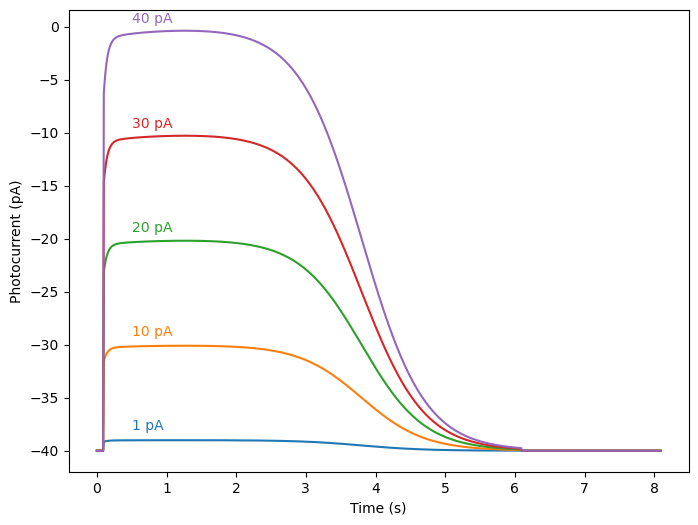

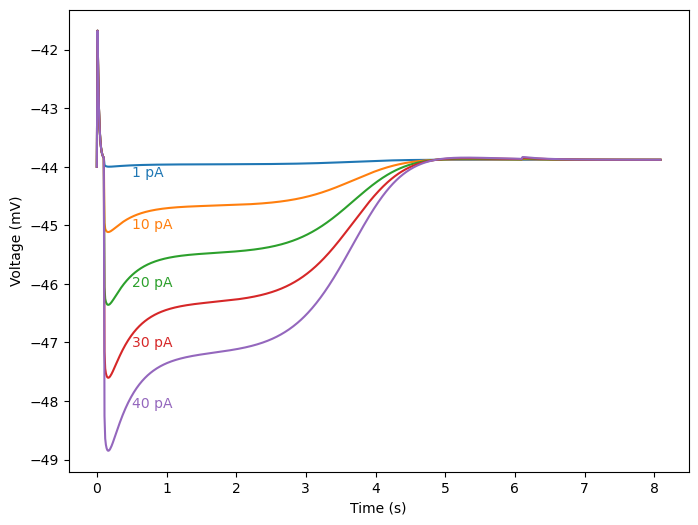

In [17]:
# Plot Ip traces
f, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, amp in enumerate(amps):
    ax.plot(M.t/second, arr_Ip[idx, :], label='{} pA'.format(amp))

    # Colored text for each trace
    y_pos = arr_Ip[idx, 50]
    ax.text(0.5, y_pos+1, '{} pA'.format(amp), color='C{}'.format(idx))
ax.set_ylabel('Photocurrent (pA)')
ax.set_xlabel('Time (s)')

# Plot voltage traces
f, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, amp in enumerate(amps):
    ax.plot(M.t/second, arr_V[idx, :], label='{} pA'.format(amp))

    # Colored text for each trace
    y_pos = arr_V[idx, 50]
    ax.text(0.5, y_pos-0.2, '{} pA'.format(amp), color='C{}'.format(idx))
# plt.legend(loc=(1.05, 0.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')

Besides the wonky initial jumps, the voltage trace basically matches the paper and NEURON outputs. However, the amplitude is off. Let's examine underlying currents for the last input amplitude of 40pA.

Text(0.5, 0, 'Time (s)')

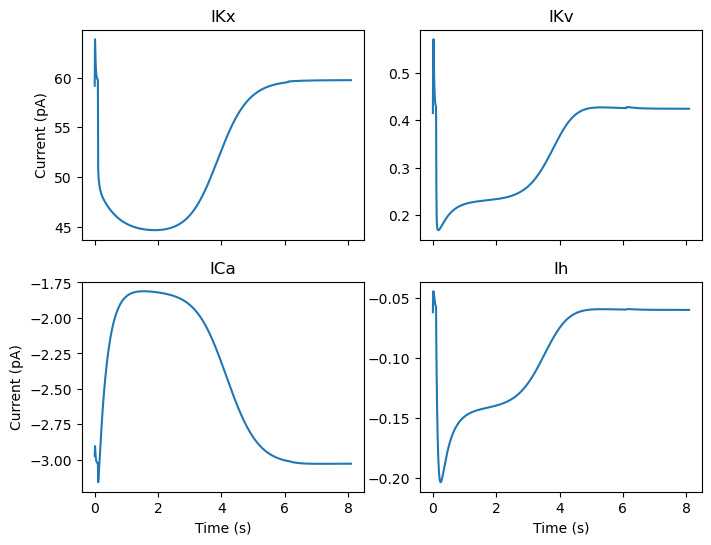

In [18]:
# Plot IKx, Ih, IKv, ICa in separate figures. This layout matches Fig 2 in Publio (2006)

f, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axs = axs.flatten()
for idx, label in enumerate(['IKx', 'IKv', 'ICa', 'Ih']):
    trace = getattr(M, label)[0]*cell_area/pA
    axs[idx].plot(M.t/second, trace)
    axs[idx].set_title(label)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Current (pA)')
axs[0].set_ylabel('Current (pA)')
axs[3].set_xlabel('Time (s)')

Fig 2 in Publio(2006)

![Fig2](https://ars.els-cdn.com/content/image/1-s2.0-S0925231205003620-gr2.gif)

These waveforms are near matches to Fig 2 in Publio (2006), but
* IKx amplitude is off by 3x
* IKv amplitude is off by 10x
* ICa amplitude is off by 2x
* Ih amplitude is off by 100x

Fixing this and translating the rest of the model is a problem for future Vyom :)

## Debugging Ih

A first attempt at fixing by looking at each component individually is trickier than it might seem as there are interactions between them. For instance, looking at Ih alone gives the right amplitude but the wrong shape.

In [19]:
# We need at least Ileak and Ip for the model to have reasonable numbers
eqs_total = '''
# Transmembrane current
Im = 0*amp/metre**2 : amp / metre**2

dV/dt = -(Ih + Ileak + Ip/(cell_area)) / Cm : volt
'''
debug_eqs = eqs_input + eqs_total + eqs_h + eqs_leak

WARNING    The name "amp" refers to different objects in different namespaces used for resolving names in the context of group "spatialneuron_1". Will use the object from the units namespace with the value amp, but the name also refers to a variable in the run namespace with value '40'. [brian2.groups.group.Group.resolve.resolution_conflict]


Text(0.5, 1.0, 'Ih (pA)')

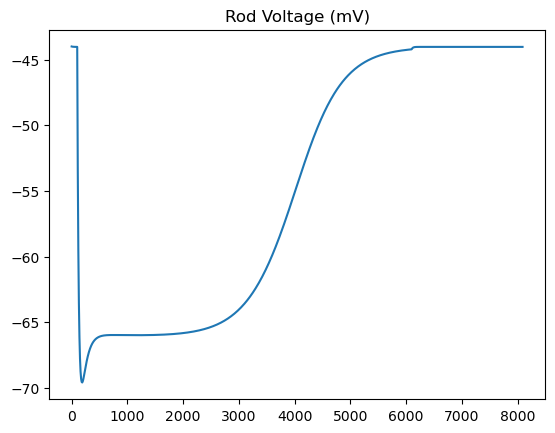

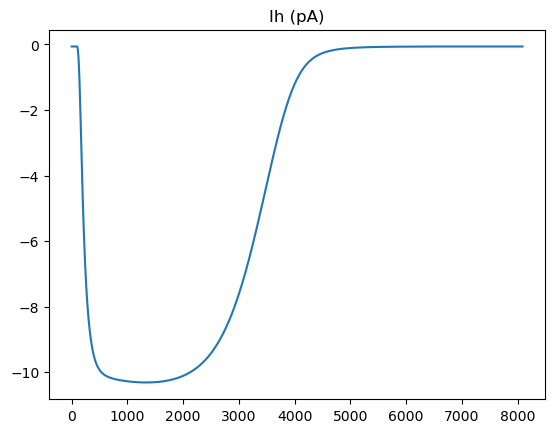

In [20]:
# Set up simulation
defaultclock.dt = 1*ms
start_scope()

morpho = Cylinder(diameter=diam, n=1, length=length)
neuron = SpatialNeuron(morphology=morpho, model=debug_eqs, Cm=membrane_capacitance, Ri=Ra, method='euler')

# Monitor voltage and Ip
M = StateMonitor(neuron, ['V', 'Ip', 'Ih', 'Ileak'],
                record=True, dt=10*ms)
neuron.V = -44*mV
neuron.A = 0*pA

# Initialize gating variables
neuron.nh = neuron.infh[:][0]

run(100*ms)
neuron.A = 40*pA
run(6000*ms)
neuron.A = 0*pA
run(2000*ms)
plot(M.t/ms, M.V[0]/mV)
plt.title('Rod Voltage (mV)')
plt.figure()
plot(M.t/ms, M.Ih[0]*cell_area/pA)
plt.title('Ih (pA)')